# Average template of slow-waves

This notebook demonstrates how to use YASA to create an average template of slow-waves, per channel.

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

**Important**
- The data must be a numpy array of shape *(n_channels, n_samples)*.
- The sampling frequency `sf` must be the same for all channels.
- A list of the channel names (`ch_names`) must be provided as well.
- The unit of the data must be $\mu V$. Note that the default unit in [MNE](https://martinos.org/mne/dev/generated/mne.io.Raw.html) is $V$. Therefore, if you use MNE, you must multiply your data by 1e6 (1 $V$ = 1,000,000 $\mu V$).

For the sake of the example, we load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

For more details on the slow-waves detection, see [06_sw_detection.ipynb](06_sw_detection.ipynb) and [07_sw_detection_multi.ipynb](07_sw_detection_multi.ipynb).

In [1]:
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)

C:\Users\Raphael\AppData\Local\Continuum\anaconda3\lib\site-packages\numba\decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


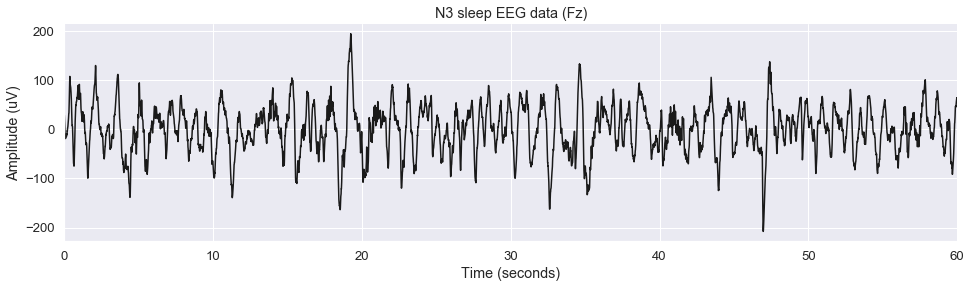

In [2]:
# Load data
data = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz').get('data')
ch_names = ['Cz', 'Fz', 'Pz']
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')

# Keep only Fz and during a N3 sleep period with slow-waves
data = data[:, 669000:675001].astype(np.float64)
hypno = hypno[669000:675001]

# Define sampling frequency and time vector
sf = 100.
times = np.arange(data.shape[1]) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data[1, :], lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data (Fz)')
sns.despine()

In [3]:
# Multi-channel slow-wave detection
sw = yasa.sw_detect_multi(data, sf, ch_names, hypno=hypno)
sw.round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,1.19,1.59,1.86,2.08,2.24,1.05,-81.00,85.18,166.18,615.50,0.95,3,Cz,0
1,3.83,4.31,4.52,4.64,4.77,0.94,-186.13,89.10,275.23,1310.62,1.06,3,Cz,0
2,5.32,5.52,5.79,6.10,6.74,1.42,-52.20,62.90,115.10,426.29,0.70,3,Cz,0
3,7.11,7.64,7.75,7.88,8.05,0.94,-47.24,67.13,114.37,1039.73,1.06,3,Cz,0
4,8.05,8.37,8.67,8.91,9.05,1.00,-50.41,34.77,85.19,283.96,1.00,3,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,46.00,46.23,46.37,46.50,46.58,0.58,-45.20,54.16,99.36,709.70,1.72,3,Pz,2
65,48.15,48.34,48.59,48.65,48.72,0.57,-115.92,11.26,127.18,508.74,1.75,3,Pz,2
66,53.05,53.24,53.39,53.51,53.93,0.88,-58.07,37.86,95.93,639.56,1.14,3,Pz,2
67,53.93,54.30,54.53,54.66,55.27,1.34,-77.89,17.74,95.63,415.78,0.75,3,Pz,2


In [4]:
# Get synchronized timing
df_sync_sw = yasa.get_sync_sw(data, sf, sw, event='NegPeak', time_before=0.4, time_after=0.8)
df_sync_sw.head()

,Time,Event,Amplitude,Channel,IdxChannel
0,-0.40,0,5.457005,Cz,0
1,-0.39,0,11.105484,Cz,0
2,-0.38,0,19.147387,Cz,0
3,-0.37,0,23.168337,Cz,0
4,-0.36,0,28.721079,Cz,0


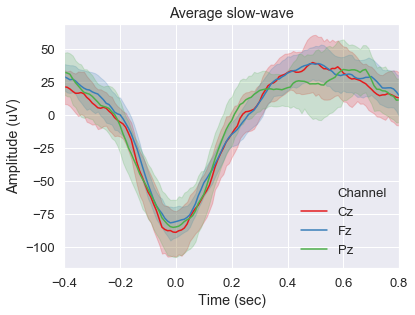

In [5]:
# Plot the average slow-wave
plt.figure(figsize=(6, 4.5))
pal = sns.color_palette("Set1", df_sync_sw['Channel'].nunique())
sns.lineplot(data=df_sync_sw, x='Time', y='Amplitude', hue='Channel', 
            palette=pal)

plt.xlim(df_sync_sw['Time'].min(), df_sync_sw['Time'].max())
plt.title('Average slow-wave')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (uV)')
plt.legend(frameon=False, loc='lower right');